# Analysis of the plans for Megaline

The company offers its clients two prepaid plans, **Surf** and **Ultimate**. The commercial department wants to know which of the plans is more profitable.
Let's study the data on 500 Megaline clients: 
- who the clients are, 
- where they're from, 
- which plan they use, and 
- the number of calls they made and text messages they sent in 2018. 

We'll analyze clients' behavior and determine which prepaid plan is more profitable.

### Step 1. Open the data files and study the general information

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:


# 1. Open all the files
files = ['megaline_calls.csv', 'megaline_internet.csv', 'megaline_messages.csv',
        'megaline_plans.csv', 'megaline_users.csv']

variables = []

for i in range(len(files)):
    variables.append( pd.read_csv(files[i]))
      
calls, data, sms, plans, users = variables


In [3]:
# 2. Let's study each file one by one. 
#    Starting from calls .

calls.info()
calls.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


In [4]:
calls.duplicated().sum()

0

In [5]:
calls.query('duration>0')['duration'].describe()

count    110901.000000
mean          8.378196
std           5.354567
min           0.010000
25%           4.150000
50%           7.710000
75%          11.820000
max          37.600000
Name: duration, dtype: float64

We're lucky for the **calls**:
- no missing values
- no duplicates
- **call_date** can be converted into *date* data type in the next step.
- **duration** can be converted into *int* data type  in the next step as the plan counts only for the whole number of minutes.
- there are **zero** values in the **duration** column. Lets' study in more detail if there are values less than 1 but not equal to 0.

In [6]:
calls.query('duration > 0 and duration <1').describe()


,user_id,duration
count,5725.000000,5725.000000
mean,1246.160699,0.505745
std,139.324635,0.283136
min,1001.000000,0.010000
25%,1126.000000,0.260000
50%,1244.000000,0.510000
75%,1364.000000,0.750000
max,1499.000000,0.990000


It looks like zero values are not just simple rounding for short calls with duration less than a minute.
The short calls are precisely logged.
Searching information on call detail records (CDR) it turns out that 0 duration means:
- the other party was busy
- the connection was not successful
- the call transfer was not successful

So we'll assume that calls with 0 duration are **unsuccessful** calls so there's nothing to be fixed here as for our future analysis we'll need only consumed minutes. 

In [7]:
# Count the share of the unsuccessful calls
print("The average share of unsuccessful calls is {:.2}".format(
    (calls.query('duration == 0')['duration'].count()) / (calls['duration'].count())))

The average share of unsuccessful calls is 0.19


It looks reasonable that every **fifth** call on average is unsuccessful. May be the network coverage is not perfect and people like to talk (median value is **~8 minutes**) so there're many 'busy subscriber' situations.

In [8]:
# 3. Moving to data sessions

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


In [9]:
data.duplicated().sum()

0

In [10]:
data.query('mb_used > 0').describe()

,user_id,mb_used
count,91078.000000,91078.000000
mean,1242.576923,422.064206
std,141.992374,255.063501
min,1000.000000,0.010000
25%,1122.000000,223.380000
50%,1236.000000,395.905000
75%,1367.000000,588.367500
max,1499.000000,1693.470000


we're also lucky with **data sessions**:
- no missing values
- no duplicates
- **session_date** can be converted into *date* data type in the next step.
- **mb_used** can be converted into *int* data type  in the next step as we assume that Megaline uses the same practice of rounding consumed KB to the whole number of MB as other mobile operators do.
- there are **zero** values in the **mb_used** column. Lets' study in more detail if there are values less than 1 but not equal to 0.

In [11]:
data.query('mb_used > 0 and mb_used <1').describe()

,user_id,mb_used
count,82.000000,82.000000
mean,1227.573171,0.457561
std,153.079019,0.293310
min,1004.000000,0.010000
25%,1085.750000,0.190000
50%,1219.000000,0.445000
75%,1351.500000,0.712500
max,1499.000000,0.950000


For the same reasons as for the calls let's assume that zero MBs consumed mean an unsuccessful session. There's nothing to do with it as we'll estimate the profit and we need non-zero values.

In [12]:
# Again let's check how reasonable the share of the unsuccessful sessions
print("The average share of unsuccessful sessions is {:.2}".format(
    (data.query('mb_used == 0')['mb_used'].count()) / (data['mb_used'].count())))

The average share of unsuccessful sessions is 0.13


The result is similar to the one with the calls but a bit lower: 'subscriber is busy' situation is not an issue for data sessions but the network coverage effect is still in place.

In [13]:
# 4. ...and the same analysis for SMS

sms.info()
sms.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


In [14]:
sms.duplicated().sum()

0

**SMS** looks even simpler:
- no missing values
- no duplicates
- **message_date** can be converted into *date* data type in the next step.

In [15]:
# 5. what's hidden under the plans?
plans.info()
plans

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


It's just a description of 2 tariff plans. Nothing to fix here, we'll just use this information for the calculations.

In [16]:
# 6. Finally, let's look at users

users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


In [17]:
users.duplicated().sum()

0

In [19]:
users['plan'].unique()

array(['ultimate', 'surf'], dtype=object)

**Users** have something to deal with:
- there're missing values in **churn_date** meaning the subscriber is still using the service. If we don't plan to use it in calculations we can skip NaN values.
- no duplicates
- **reg_date** and **churn_date** can be converted into *date* data type in the next step.
- we also checked that **only two** tariff plans are used in users and they match the plans dataset.

### Step 2. Prepare the data
Here we'll:
- convert the data to the necessary types as discussed in the step 1
    - calls **call_date** to date data type and **duration** round up to int
    - data **session_date** to date data type and **mb_used** round up to int
    - SMS **message_date** to date data type
    - users **reg_date** and **churn_date** to date data type
- find and eliminate errors in the data if any
    - we decided that zero values from calls/data should not be touched as they do not influence the profit (just the number of calls/sessions)
    - let's check data consistency: we can make sure that transaction dates are **between** *registration date* and *churn date* (if the date available). Any transactions outside the range are invalid and should be omited.
- add month and year columns to each dataset as our calculations will use it.
    

For each user, we'll find:

- The number of calls (total, successfull, unsuccessful) made and minutes used per month
- The number of text messages sent per month
- The volume of data per month
- The monthly profit from each user calculated as:
    - subtract the free package limit from the total number of calls, text messages, and data; 
    - multiply the result by the calling plan value; 
    - add the monthly charge depending on the calling plan

In [20]:
# 1. Let's convert:
try:
    calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
    data['session_date'] = pd.to_datetime(data['session_date'], format='%Y-%m-%d')
    sms['message_date'] = pd.to_datetime(sms['message_date'], format='%Y-%m-%d')
    users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
    users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
except:
    print("Convertion error occured!")

calls['duration'] = calls['duration'].apply('ceil')
data['mb_used'] = data['mb_used'].apply('ceil')
try:
    calls['duration'] =calls['duration'].astype('int')
    data['mb_used'] = data['mb_used'].astype('int')
except:
    print("Duration or MBs convertion error occured!")

# ... and check the results
names = ['calls', 'data', 'sms', '', 'users']
for i in range(len(variables)):
    if i==3:
        continue
    print('== {} =='.format(names[i]))
    print()
    variables[i].info()
    print('\n\n')    

== calls ==

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  int32         
dtypes: datetime64[ns](1), int32(1), int64(1), object(1)
memory usage: 3.7+ MB



== data ==

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  int32         
dtypes: datetime64[ns](1), int32(1), int64(1), object(1)
memory usage: 2.8+ MB


In [21]:
# 2. Let's check the data consistency:
#    make sure that transaction dates are between registration date and churn date.

# merge calls/sessions/messages with users dataset on user_id and compare dates
calls_users = calls.merge(users, on='user_id',how='inner')
data_users = data.merge(users, on='user_id',how='inner')
sms_users = sms.merge(users, on='user_id',how='inner')

# check transactions before registration date
calls_before_reg = calls_users.query('call_date < reg_date')['id'].count()
sessions_before_reg = data_users.query('session_date < reg_date')['id'].count()
messages_before_reg = sms_users.query('message_date < reg_date')['id'].count()

if calls_before_reg>0 or sessions_before_reg>0 or messages_before_reg>0:
    print("There's data incosistency related to registration date")
else:
    print("All transactions were made after registration date")

# check transactions after churn    
calls_after_churn = calls_users.query('call_date > churn_date')['id'].count()
sessions_after_churn = data_users.query('session_date > churn_date')['id'].count()
messages_after_churn = sms_users.query('message_date > churn_date')['id'].count()

if calls_after_churn>0 or sessions_after_churn>0 or messages_after_churn>0:
    print("There's data incosistency related to churn date")
    print("Calls after churn:", calls_after_churn)
    print("Sessions after churn:", sessions_after_churn)
    print("Messages after churn:", messages_after_churn)
else:
    print("All transactions were made before churn date")


All transactions were made after registration date
There's data incosistency related to churn date
Calls after churn: 2961
Sessions after churn: 2463
Messages after churn: 1591


In [22]:
calls_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137735 entries, 0 to 137734
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id          137735 non-null  object        
 1   user_id     137735 non-null  int64         
 2   call_date   137735 non-null  datetime64[ns]
 3   duration    137735 non-null  int32         
 4   first_name  137735 non-null  object        
 5   last_name   137735 non-null  object        
 6   age         137735 non-null  int64         
 7   city        137735 non-null  object        
 8   reg_date    137735 non-null  datetime64[ns]
 9   plan        137735 non-null  object        
 10  churn_date  8999 non-null    datetime64[ns]
dtypes: datetime64[ns](3), int32(1), int64(2), object(5)
memory usage: 12.1+ MB


In [23]:
data_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104825 entries, 0 to 104824
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  int32         
 4   first_name    104825 non-null  object        
 5   last_name     104825 non-null  object        
 6   age           104825 non-null  int64         
 7   city          104825 non-null  object        
 8   reg_date      104825 non-null  datetime64[ns]
 9   plan          104825 non-null  object        
 10  churn_date    7466 non-null    datetime64[ns]
dtypes: datetime64[ns](3), int32(1), int64(2), object(5)
memory usage: 9.2+ MB


In [24]:
sms_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76051 entries, 0 to 76050
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
 3   first_name    76051 non-null  object        
 4   last_name     76051 non-null  object        
 5   age           76051 non-null  int64         
 6   city          76051 non-null  object        
 7   reg_date      76051 non-null  datetime64[ns]
 8   plan          76051 non-null  object        
 9   churn_date    4397 non-null   datetime64[ns]
dtypes: datetime64[ns](3), int64(2), object(5)
memory usage: 6.4+ MB


No missing data for the _plan_ field in the merged data so we have the required information for every transaction.

We should fix transactions data and get rid of invalid or suspicious transactions made after end of service

In [25]:
# we should fix transactions data and get rid of invalid or suspicious transactions made after end of service

bad_ids = calls_users.query('call_date > churn_date')['id'].unique()
calls = pd.DataFrame(calls.query('id not in @bad_ids'))
calls['id'].count()

134774

In [26]:
bad_ids = data_users.query('session_date > churn_date')['id'].unique()
data = pd.DataFrame(data.query('id not in @bad_ids'))
data['id'].count()

102362

In [27]:
bad_ids = sms_users.query('message_date > churn_date')['id'].unique()
sms = pd.DataFrame(sms.query('id not in @bad_ids'))
sms['id'].count()

74460

The number of transactions in the *reduced* dataset is equal the *original* transactions number minus # of transactions *after churn*:

- 134 774 = 137 735 - 2961
- 102 362 = 104 825 - 2463
- 74 460 = 76 051- 1591

In [32]:
# 3. Let's add month and year columns to calls, data and sms datasets:


calls['month'] = pd.DatetimeIndex(calls['call_date']).month
calls['year'] = pd.DatetimeIndex(calls['call_date']).year
data['month'] = pd.DatetimeIndex(data['session_date']).month
data['year'] = pd.DatetimeIndex(data['session_date']).year
sms['month'] = pd.DatetimeIndex(sms['message_date']).month
sms['year'] = pd.DatetimeIndex(sms['message_date']).year

# and check the results

calls.head()


,id,user_id,call_date,duration,month,year
0,1000_93,1000,2018-12-27,9,12,2018
1,1000_145,1000,2018-12-27,14,12,2018
2,1000_247,1000,2018-12-27,15,12,2018
3,1000_309,1000,2018-12-28,6,12,2018
4,1000_380,1000,2018-12-30,5,12,2018


In [28]:
data.head()


,id,user_id,session_date,mb_used,month,year
0,1000_13,1000,2018-12-29,90,12,2018
1,1000_204,1000,2018-12-31,0,12,2018
2,1000_379,1000,2018-12-28,661,12,2018
3,1000_413,1000,2018-12-26,271,12,2018
4,1000_442,1000,2018-12-27,881,12,2018


In [29]:
sms.head()

,id,user_id,message_date,month,year
0,1000_125,1000,2018-12-27,12,2018
1,1000_160,1000,2018-12-31,12,2018
2,1000_223,1000,2018-12-31,12,2018
3,1000_251,1000,2018-12-27,12,2018
4,1000_255,1000,2018-12-26,12,2018


Let's see how many years are covered by the data and whether we need take it into account when gourping data by month

In [30]:
# 4. Let's see how many years are covered by the data 
# and whether we need take it into account when gourping data by month
print("The list of years covered by calls dataset:", calls['year'].unique())
print("The list of years covered by data sessions dataset:", data['year'].unique())
print("The list of years covered by sms dataset:", sms['year'].unique())



The list of years covered by calls dataset: [2018]
The list of years covered by data sessions dataset: [2018]
The list of years covered by sms dataset: [2018]


Seems only year 2018 is in the datasets, so we can build pivot tables just grouping by months (and not by months+years)

In [33]:
# 5. Seems only year 2018 is in the datasets, 
#   so we can build pivot tables just grouping by months (and not by months+years)

#  number of minutes per user per month
#calls_mins = calls.groupby(['user_id', 'month'])['duration'].sum()
calls_mins = calls.pivot_table(index='user_id', columns='month', values='duration', aggfunc='sum', fill_value=0)
calls_mins.head()

month,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,0,0,0,0,0,0,0,0,0,0,0,124
1001,0,0,0,0,0,0,0,182,315,393,426,412
1002,0,0,0,0,0,0,0,0,0,59,386,384
1003,0,0,0,0,0,0,0,0,0,0,0,1104
1004,0,0,0,0,193,275,381,354,301,365,476,427


In [34]:
#  total number of calls per user per month
calls_total = calls.pivot_table(index='user_id', columns='month', values='id', aggfunc='count',  fill_value=0)
calls_total.head()

month,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,0,0,0,0,0,0,0,0,0,0,0,16
1001,0,0,0,0,0,0,0,27,49,65,64,56
1002,0,0,0,0,0,0,0,0,0,11,55,47
1003,0,0,0,0,0,0,0,0,0,0,0,149
1004,0,0,0,0,21,44,49,49,42,61,54,50


In [33]:
#  number of successful calls per user per month
calls_succ = calls.query('duration >0').pivot_table(index='user_id', columns='month', values='id', aggfunc='count', fill_value=0)
calls_succ.head()

month,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,0,0,0,0,0,0,0,0,0,0,0,16
1001,0,0,0,0,0,0,0,22,38,47,49,46
1002,0,0,0,0,0,0,0,0,0,8,48,38
1003,0,0,0,0,0,0,0,0,0,0,0,118
1004,0,0,0,0,19,33,45,42,32,47,45,43


In [35]:
#  number of unsuccessful calls per user per month
calls_unsucc = calls.query('duration == 0').pivot_table(index='user_id', columns='month', values='id', aggfunc='count', fill_value=0)
calls_unsucc.head()

month,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1001,0,0,0,0,0,0,0,5,11,18,15,10
1002,0,0,0,0,0,0,0,0,0,3,7,9
1003,0,0,0,0,0,0,0,0,0,0,0,31
1004,0,0,0,0,2,11,4,7,10,14,9,7
1005,0,0,0,0,0,0,0,0,0,0,0,9


In [36]:
#  number of messages per user per month
messages_month = sms.pivot_table(index='user_id', columns='month', values='id', aggfunc='count', fill_value=0)
messages_month.head()


month,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,0,0,0,0,0,0,0,0,0,0,0,11
1001,0,0,0,0,0,0,0,30,44,53,36,44
1002,0,0,0,0,0,0,0,0,0,15,32,41
1003,0,0,0,0,0,0,0,0,0,0,0,50
1004,0,0,0,0,7,18,26,25,21,24,25,31


In [37]:
#  number of MB per user per month

traffic_month = data.pivot_table(index='user_id', columns='month', values='mb_used', 
                                 aggfunc='sum',  fill_value=0)
traffic_month.head()


month,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,0,0,0,0,0,0,0,0,0,0,0,1903
1001,0,0,0,0,0,0,0,6929,13333,22356,18524,19398
1002,0,0,0,0,0,0,0,0,0,6559,19364,14416
1003,0,0,0,0,0,0,0,0,0,0,0,27069
1004,0,0,0,0,6554,20702,24547,28015,18874,14564,21882,21410


Calculate the profit per month for each user.

In [45]:
# Create an empty DF
profit_alt = pd.DataFrame(index=users['user_id'], columns=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], data=[[0]*12]*500)

users['reg_month'] = pd.DatetimeIndex(users['reg_date']).month
users['churn_month'] = pd.DatetimeIndex(users['churn_date']).month

#Add columns: registration and churn months + tariff details
profit_users = profit_alt.merge(users[['user_id', 'reg_month', 'churn_month', 'plan']], left_index=True, right_on='user_id')
profit_users = profit_users.merge(plans, left_on='plan', right_on='plan_name', how='left')
profit_users = profit_users.set_index('user_id')
# fill with NaN profit values of inactivity period
for i in range(1,13):
    profit_users.loc[i < profit_users['reg_month'], str(i)] = np.NaN
    profit_users.loc[i > profit_users['churn_month'], str(i)] = np.NaN    

#supplementary Series object with zeros    
zero = pd.Series(index=users['user_id'], data=0)    

def get_profit():
    
    mins_limit = profit_users['minutes_included']
    MB_limit = profit_users['mb_per_month_included']
    messages_limit = profit_users['messages_included']
    price_month = profit_users['usd_monthly_pay']
    price_GB = profit_users['usd_per_gb']
    price_sms = profit_users['usd_per_message']
    price_min = profit_users['usd_per_minute']
    
    #prepare tables for transactions adding all the users to have the same shape
    mins_used = calls_mins.merge(users[['user_id']], left_index=True, right_on='user_id', how='outer')
    mins_used = mins_used.set_index('user_id').sort_index()
    mins_used = mins_used.fillna(0)
    
    MB_used = traffic_month.merge(users[['user_id']], left_index=True, right_on='user_id', how='outer')
    MB_used = MB_used.set_index('user_id').sort_index()
    MB_used = MB_used.fillna(0)
    
    messages_used = messages_month.merge(users[['user_id']], left_index=True, right_on='user_id', how='outer')
    messages_used = messages_used.set_index('user_id').sort_index()
    messages_used = messages_used.fillna(0)
    
    # Add monthly price 
    profit_users.loc[:,'1':'12'] = profit_users.loc[:,'1':'12'].add(price_month, axis=0)
    # for each month calculate overhead and add to profit
    for i in range(1,13):        

        profit_users [str(i)] = profit_users[str(i)] + np.maximum(zero,(mins_used.iloc[:,i-1] - mins_limit)) * price_min
        profit_users [str(i)] = profit_users[str(i)] + np.ceil(np.maximum(zero,(MB_used.iloc[:,i-1] - MB_limit))/1024) * price_GB
        profit_users [str(i)] = profit_users[str(i)] + np.maximum(zero,(messages_used.iloc[:,i-1] - messages_limit)) * price_sms

get_profit()        
profit = profit_users.loc[:,'1':'12']
profit.head()    


,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.00
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,20.0,90.09,60.0,60.00
1002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.00,60.0,20.00
1003,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.00,20.0,158.12
1004,NaN,NaN,NaN,NaN,20.0,80.0,110.0,150.0,60.0,20.00,90.0,80.00


### Step 3. Analyze the data

Let's describe the customers' behavior. 
- Find the minutes, texts, and volume of data the users of each plan require per month. 
- Calculate the mean, dispersion, and standard deviation. 
- Plot histograms. 
- Describe the distributions. 

In [42]:
calls_tariff = calls.merge(users[['user_id', 'plan']])
data_tariff = data.merge(users[['user_id', 'plan']])
sms_tariff = sms.merge(users[['user_id', 'plan']])

# aggregate the data per user per month and total minutes, text and data volume consumed by that user_id that month

sms_monthly_plan = sms_tariff.groupby(['user_id', 'month']).agg({'id':'count', 'plan': 'first'})
sms_monthly_plan

id      plan
user_id month              
1000    12     11  ultimate
1001    8      30      surf
        9      44      surf
        10     53      surf
        11     36      surf
...            ..       ...
1496    9      21      surf
        10     18      surf
        11     13      surf
        12     11      surf
1497    12     50  ultimate

[1777 rows x 2 columns]

In [43]:
calls_monthly_plan = calls_tariff.groupby(['user_id', 'month']).agg({'duration':'sum', 'plan': 'first'})
calls_monthly_plan

duration      plan
user_id month                    
1000    12          124  ultimate
1001    8           182      surf
        9           315      surf
        10          393      surf
        11          426      surf
...                 ...       ...
1498    12          339      surf
1499    9           346      surf
        10          385      surf
        11          308      surf
        12          496      surf

[2221 rows x 2 columns]

In [44]:
data_monthly_plan = data_tariff.groupby(['user_id', 'month']).agg({'mb_used':'sum', 'plan': 'first'})
data_monthly_plan

mb_used      plan
user_id month                   
1000    12        1903  ultimate
1001    8         6929      surf
        9        13333      surf
        10       22356      surf
        11       18524      surf
...                ...       ...
1498    12       23160      surf
1499    9        13004      surf
        10       19515      surf
        11       16834      surf
        12       22091      surf

[2240 rows x 2 columns]

Now let's analyze the data by plan.
We continue with previously aggregated data.

In [43]:
calls_monthly_plan.groupby('plan').agg({'duration':['mean', 'median', 'std', 'var'] })

duration                                 
                mean median         std           var
tariff                                               
surf      433.648684    427  230.306871  53041.255034
ultimate  433.273894    427  239.106418  57171.879160

In [44]:
data_monthly_plan.groupby('plan').agg({'mb_used':['mean','median', 'std', 'var'] })

mb_used                                  
                  mean median          std           var
tariff                                                  
surf      16636.671233  16833  7917.754884  6.269084e+07
ultimate  17205.123055  16871  7894.485784  6.232291e+07

In [45]:
sms_monthly_plan.groupby('plan').agg({'id':['mean', 'median', 'std', 'var'] })

id                               
               mean median        std          var
tariff                                            
surf      39.762261     32  33.074690  1093.935114
ultimate  46.386760     41  32.874613  1080.740208

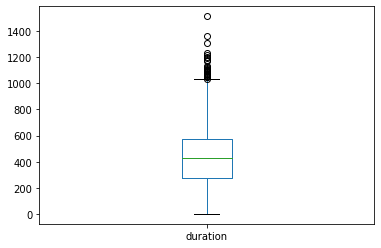

In [46]:
calls_monthly_plan.query('duration>0 and plan =="surf"')['duration'].plot(kind='box')


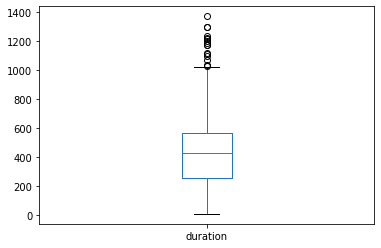

In [47]:
calls_monthly_plan.query('duration>0 and plan =="ultimate"')['duration'].plot(kind='box')

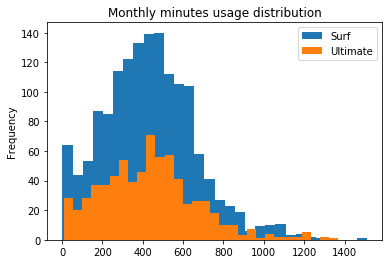

In [48]:
calls_monthly_plan.query('duration>0 and plan =="surf"')['duration'].plot(kind='hist', bins=30, label='Surf', legend=True, title="Monthly minutes usage distribution")
calls_monthly_plan.query('duration>0 and plan =="ultimate"')['duration'].plot(kind='hist', bins=30, label='Ultimate', legend=True)

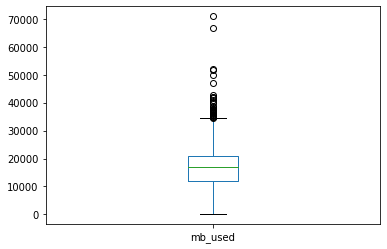

In [49]:
data_monthly_plan.query('mb_used>0 and plan =="surf"')['mb_used'].plot(kind='box')

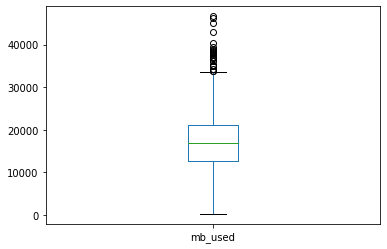

In [50]:
data_monthly_plan.query('mb_used>0 and plan =="ultimate"')['mb_used'].plot(kind='box')

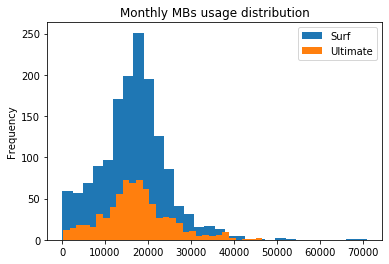

In [51]:
data_monthly_plan.query('mb_used>0 and plan =="surf"')['mb_used'].plot(kind='hist', bins=30, label='Surf', legend=True,title="Monthly MBs usage distribution")
data_monthly_plan.query('mb_used>0 and plan =="ultimate"')['mb_used'].plot(kind='hist', bins=30, label='Ultimate', legend=True)

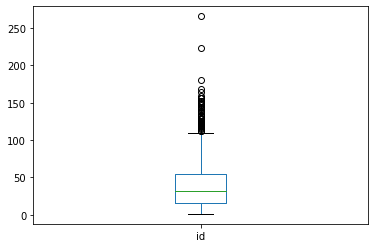

In [52]:
sms_monthly_plan.query('plan =="surf"')['id'].plot(kind='box')

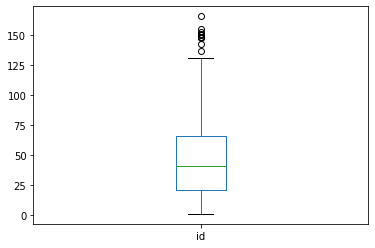

In [53]:
sms_monthly_plan.query('plan =="ultimate"')['id'].plot(kind='box')

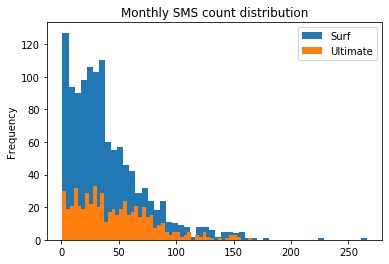

In [54]:
sms_monthly_plan.query('plan =="surf"')['id'].plot(kind='hist', bins=50, label='Surf', legend=True, title="Monthly SMS count distribution")
sms_monthly_plan.query('plan =="ultimate"')['id'].plot(kind='hist', bins=50, label='Ultimate', legend=True)

## Results:

Regarding calls users of both plans use approx. the same minutes per month (433 mins) with quite large standard deviation (~230 minutes). Median (427 mins) is less than the mean so the distributions are slightly skewed to the right.<br>

Regarding traffic monthly usage the median is approx.the same (~16 800) with similar deviations, but the mean for Surf is less the median while for Ultimate it's more, so Surf traffic usage distribution is slightly skewed to the left while Ultimate  distribution is skewed to the right.<br>

What concerns SMS Ultimate users send  more messages per month (mean = 46) than Surf users (mean = ~40) while the deviations are close to each other.

From box plots we see that Ultimate service usage has a wider IQR compared to Surf usage.<br>

SMS are almost evenly distributed in the range from 1 to ~40 for both plans in the range >40 SMS frequency decreases for the Surf users (probably due to plan limitations) while for ultimate users in the range from 40 to ~70 there's again almost equal frequency though a bit lower than for the range below 40.
 

Now let's observe the monthly profit distribution per user.

In [47]:
# Let's reuse already calculated profit from pivot_table profit and compose a grouped version of it
profit_grouped = profit.stack()
profit_grouped.index.set_names(['user_id', 'month'], inplace=True)
profit_tariff = pd.merge(profit_grouped.reset_index(),
      users[['user_id', 'plan']],
      on=['user_id'],
      how='inner'
     ).set_index(['user_id','month']).rename(columns={0:'profit'})
profit_tariff

profit      plan
user_id month                  
1000    12      70.00  ultimate
1001    8       20.00      surf
        9       20.00      surf
        10      90.09      surf
        11      60.00      surf
...               ...       ...
1499    8       20.00      surf
        9       20.00      surf
        10      70.00      surf
        11      40.00      surf
        12      90.00      surf

[3313 rows x 2 columns]

In [48]:
profit_tariff.groupby('plan').agg({'profit':['mean', 'median', 'std', 'var'] })

profit                               
               mean median        std          var
plan                                              
surf      47.798403   20.0  49.677726  2467.876450
ultimate  71.555556   70.0   9.481534    89.899481

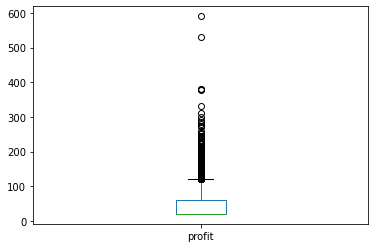

In [49]:
profit_tariff.query('plan =="surf"')['profit'].plot(kind='box')

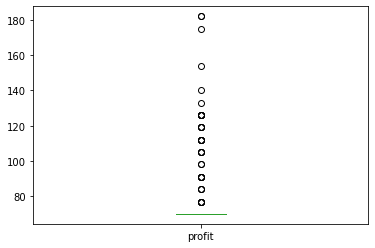

In [50]:
profit_tariff.query('plan =="ultimate"')['profit'].plot(kind='box')

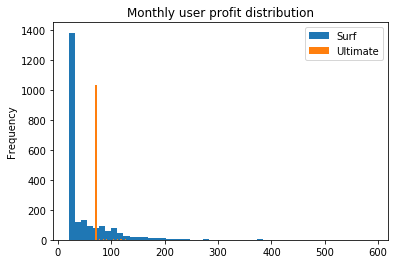

In [59]:
profit_tariff.query('plan =="surf"')['profit'].plot(kind='hist', bins=50, label='Surf', legend=True, title="Monthly user profit distribution")
profit_tariff.query('plan =="ultimate"')['profit'].plot(kind='hist', bins=50, label='Ultimate', legend=True)

## Results

We've got an interesting picture:

Surf profit is heavily skewed to the right: while the most common profit is 20 (plan's monthly price) which is at the same time the median, the mean value is 47 and the deviation is quite big: 49.7 which means there're a lot of outliers with high values. The top profit values go up to 600 which is even higher then top values for Ultimate profit (up to 180).
    
Ultimate profit is strongly concentrated around the plan monthly price of 70, which is the median and the most common value. The deviation is relatively small.
    
Some Surf users significantly overpay the package price while Ultimate users mainly sit inside the package limits.
As the median is 20 for Surf users, 50% of Surf , monthly payments are less than 20 dollars (in this case exactly 20, as that is the monthly price). Those values going up to 600 seem to be outliers. 
    


Let's plot monthly consumption of minutes/MBs/messages for each plan for all users in total

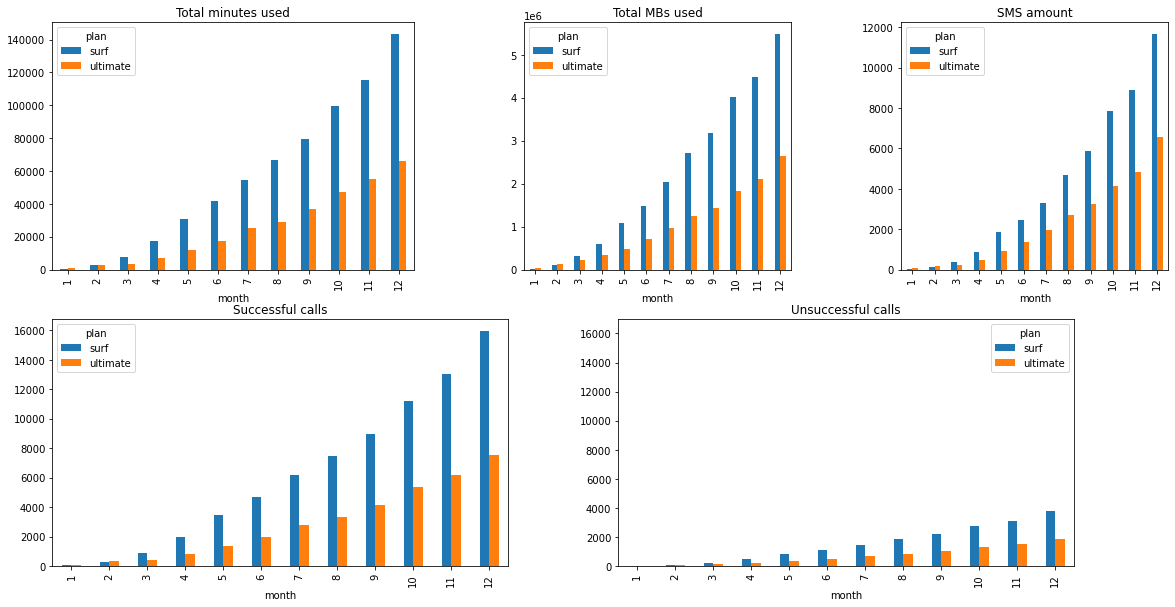

In [51]:
# Let's plot monthly consumption of minutes/MBs/messages for each plan for all users in total


fig = plt.figure(figsize=(20, 10))

ax1 = plt.subplot2grid((2, 12), (0, 0), colspan=4)
ax1.set_title('Total minutes used', fontsize=12)
ax2 = plt.subplot2grid((2, 12), (0, 5), colspan=3)
ax2.set_title('Total MBs used', fontsize=12)
ax3 = plt.subplot2grid((2, 12), (0, 9), colspan=3)
ax3.set_title('SMS amount', fontsize=12)
ax4 = plt.subplot2grid((2, 12), (1, 0), colspan=5)
ax4.set_title('Successful calls', fontsize=12)
ax5 = plt.subplot2grid((2, 12), (1, 6), colspan=5)
ax5.set_title('Unsuccessful calls', fontsize=12)
ax5.set_ylim(0, 17000)


calls_tariff.groupby(['plan', 'month'])['duration'].sum().unstack(level=0).plot(kind='bar', ax=ax1)
data_tariff.groupby(['plan', 'month'])['mb_used'].sum().unstack(level=0).plot(kind='bar', ax=ax2)
sms_tariff.groupby(['plan', 'month'])['id'].count().unstack(level=0).plot(kind='bar', ax=ax3)
calls_tariff.query('duration > 0').groupby(['plan', 'month'])['duration'].count().unstack(level=0).plot(kind='bar', ax=ax4)
calls_tariff.query('duration == 0').groupby(['plan', 'month'])['duration'].count().unstack(level=0).plot(kind='bar', ax=ax5)


plt.show()



- **Surf** is used *more* than **Ultimate**: Surf is cheaper so *maybe* more users buy it and use it. Though package limits for Surf are less it wins in total numbers due to more subscribers using it (*need to confirm it*).
- There's a **rapid** traffic *growth* from month to month for all 3 types of services. It seems that Megaline's subscriber base has been rapidly growing in 2018.
- As the number of **successful** calls grows the number of **unsuccessful** calls proportionally grows.


In [58]:
# Let's confirm our guess about the number of Surf users: 
print(users.groupby('plan')['user_id'].count())


plan
surf        339
ultimate    161
Name: user_id, dtype: int64


Now let's examine an average user from each plan:
- what's an average call duration (as 0 duration is an unsuccessful call we do not take them into account)
- what's the average volume of data per session (as 0 volume is an unsuccessful session we do not take them into account)
- what's the average number of sms/minutes/MBs used per user 


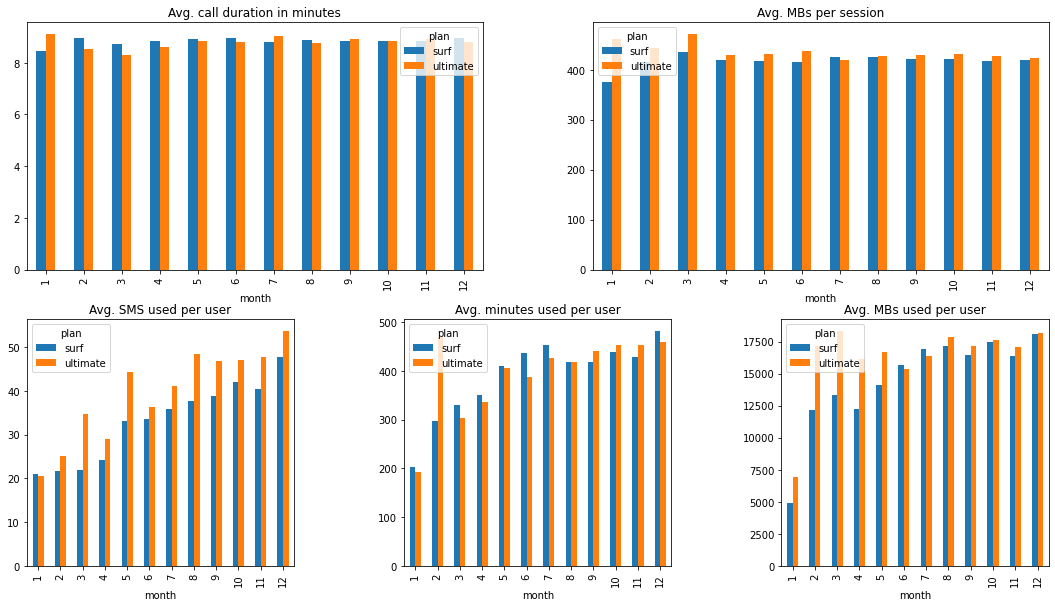

In [53]:
fig = plt.figure(figsize=(20, 10))

ax1 = plt.subplot2grid((2, 12), (0, 0), colspan=5)
ax1.set_title('Avg. call duration in minutes', fontsize=12)
ax2 = plt.subplot2grid((2, 12), (0, 6), colspan=5)
ax2.set_title('Avg. MBs per session', fontsize=12)
ax3 = plt.subplot2grid((2, 12), (1, 0), colspan=3)
ax3.set_title('Avg. SMS used per user', fontsize=12)
ax4 = plt.subplot2grid((2, 12), (1, 4), colspan=3)
ax4.set_title('Avg. minutes used per user', fontsize=12)
ax5 = plt.subplot2grid((2, 12), (1, 8), colspan=3)
ax5.set_title('Avg. MBs used per user', fontsize=12)



calls_tariff.query('duration>0').groupby(['plan', 'month'])['duration'].mean().unstack(level=0).plot(kind='bar', ax=ax1)
data_tariff.query('mb_used>0').groupby(['plan', 'month'])['mb_used'].mean().unstack(level=0).plot(kind='bar', ax=ax2)
sms_tariff.groupby(['plan', 'month', 'user_id'])['id'].count().mean(level=['plan','month']).unstack(level=0).plot(kind='bar', ax=ax3)
calls_tariff.query('duration>0').groupby(['plan', 'month', 'user_id'])['duration'].sum().mean(level=['plan','month']).unstack(level=0).plot(kind='bar', ax=ax4)
data_tariff.query('mb_used>0').groupby(['plan', 'month', 'user_id'])['mb_used'].sum().mean(level=['plan','month']).unstack(level=0).plot(kind='bar', ax=ax5)

plt.show()

- Average call duration is almost the same for both plans and is long enough **~8 minutes**
- Average per session data traffic is also nearly the same for both plans: **~410 MB**
- Monthly SMS usage per average user was growing for both plans (from **~20 SMS to ~50 SMS** per month) but **Ultimate** average user sent more messages per month than the user of **Surf** plan. At the same time the total amount of SMS usage as we saw above shows an opposite picture. It seems that **1 000** SMS included into Ultimate plan is not really used by the average user.
- Call minutes per month were also growing during the year (from **~200 to ~480** minutes per month).
- From *March to July* **Surf** user talked **more** than **Ultimate** user. In February Ultimate average user talked  **~1.5 times** more  than Surf user (500 minutes against 300 minutes). It could be a promotion action for Ultimate users. From August to Decembre the used minutes were almost equal (Ultimate used slightly more) except Decembre again with Surf user talking more.
- It seems for the average user from both plans **500 minutes** per month is suffcient. Again Ultimate plan offers **3000** which is more than used in average.
- From *January to May* Ultimate users also used significantly more MBs (~40% more) than Surf users. Again maybe there was a promotion. For the rest of the year MBs usage was almost equal for both plans.
- During the year monthly data usage increased from **5 000-7 500 MB** to **17 500 MB** in the end of the year. Here's the key for the **extra profit**: *Surf* limit is **15 GB** while starting from June average Surf user started using **more** than 15 GB monthly (actually the same amount as Ultimate users). As for Ultimate average user **17 GB** is enough and 30 GB from the plan is an overhead.

Let's consider now **distributions** examing the last month in the year as it contains the most number of transactions making statistics calculations more accurate.

Let's look at successful calls and sessions:
- duration
- mb_used
- number of messages
- user age

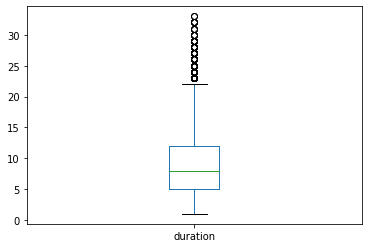

In [70]:
calls_tariff.query('month == 12 and duration > 0 ')['duration'].plot(kind='box')

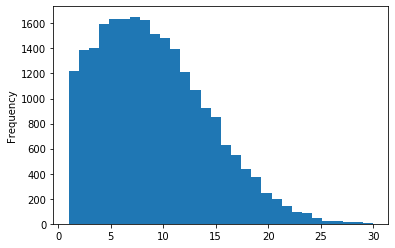

In [71]:
# From the boxplot we see that median duration is ~8 minutes with more values to the right (skewed positively)
# Though outliers begin from 23 mins let's build a histogram limiting values by half an hour 
calls_tariff.query('month == 12 and duration > 0  and duration < 31')['duration'].plot(kind='hist', bins=30)

The histogram has a bell shape similar to normal shape cut from the left and skewed to the right. People mainly talk around **8 minutes** within 1 to 12 minutes range.
Let's get more accurate numbers.

In [72]:
calls_dec = calls_tariff.query('month == 12 and duration > 0  and duration < 31')['duration']
print("The variance of call duration in decembre is:", np.var(calls_dec))
calls_dec.describe()

The variance of call duration in decembre is: 28.540154976408083


count    23483.000000
mean         8.903973
std          5.342412
min          1.000000
25%          5.000000
50%          8.000000
75%         12.000000
max         30.000000
Name: duration, dtype: float64

So as we saw from the histogram 8 minutes is a median while $\mu$ =  8.9 is mean value which is higher because of skewness to the right (a long tail of long calls).
The standatd deviation is $\sigma$ = **5.34** and the variance is **28.54** which is $\sigma^2$

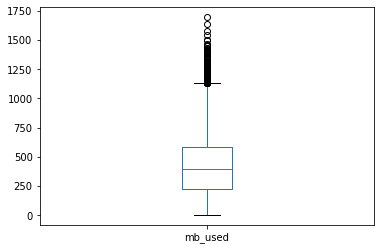

In [73]:
data_tariff.query('month == 12 and mb_used > 0')['mb_used'].plot(kind='box')

The median is almost in the middle of 1st and 3d quartile but still there's a tail to the right so the distribution should be skewed to the right. let's take range up to 1 250 MBs.

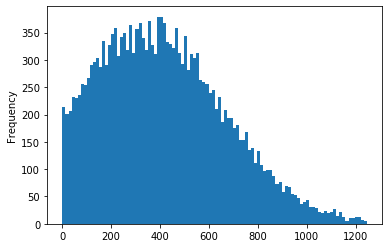

In [74]:
data_tariff.query('month == 12 and mb_used > 0  and mb_used < 1250')['mb_used'].plot(kind='hist', bins=100)

Again a bell shape similar to normal distribution but cut from the left and that's why **positively skewed**.

In [75]:
data_dec = data_tariff.query('month == 12 and mb_used > 0  and mb_used < 1250')['mb_used']
print("The variance of MBs used in decembre is:", np.var(data_dec))
data_dec.describe()

The variance of MBs used in decembre is: 62750.343538913454


count    19222.000000
mean       418.983092
std        250.506703
min          1.000000
25%        221.000000
50%        397.000000
75%        584.000000
max       1246.000000
Name: mb_used, dtype: float64

Median (397 MB) and mean (418 MB) are almost the same while the deviation is more than half the mean, so people mainly use internet from short sessions with 150 MB up to longer sessions with 670 MB volume.

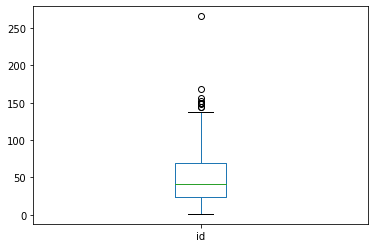

In [76]:
sms_tariff.query('month == 12 ').groupby('user_id')['id'].count().plot(kind='box')

SMS count has skewness to the right but up to 75% of users send not more than ~70 SMS. There's a long tail from 70 to ~140 with outliers up to 250 SMS.
Let's build a histogram for the range not more than 70 messages.

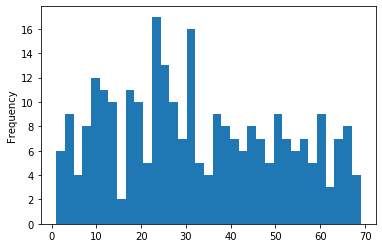

In [77]:
sms_filtered = sms_tariff.query('month == 12 ').groupby('user_id').filter(lambda x: x['id'].count() < 70)
sms_filtered.groupby('user_id')['id'].count().plot(kind='hist', bins=35)

As there's no much statistics (500 users sample can be small to analyze SMS) the shape is not accurate compared to the previous shapes. Except several peaks it looks mainly as a uniform distribution meaning any SMS count is equally possible (but of course it's not that accurate, just an approximation). 

In [78]:
sms_dec = sms_filtered.groupby('user_id')['id'].count()
print("The variance of MBs used in decembre is:", np.var(sms_dec))
sms_dec.describe()

The variance of MBs used in decembre is: 350.92051570247935


count    275.000000
mean      32.614545
std       18.767026
min        1.000000
25%       17.000000
50%       31.000000
75%       48.000000
max       69.000000
Name: id, dtype: float64

The mean and median are almost the same (32.6 and 31) with a deviation of 18.7. 

In [79]:
users['age'].describe()

count    500.000000
mean      45.486000
std       16.972269
min       18.000000
25%       30.000000
50%       46.000000
75%       61.000000
max       75.000000
Name: age, dtype: float64

Age mean and median are almost the same: 45.48 and 46.

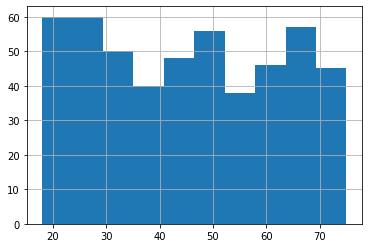

In [80]:
users['age'].hist()

Again something like uniform distribution but the histogram can fool us.
Let's use quartiles to build a categorization function and look how services usage depends on the age.

In [81]:
# define age categories and add a column with the category

def get_age_category(age):
    if age>=18 and age<30:
        return '18-29'
    if age>=30 and age<46:
        return '30-45'
    if age>=46 and age<61:
        return '46-60'
    if age>=61:
        return '60+'
users['age_cat'] = users['age'].apply(get_age_category)


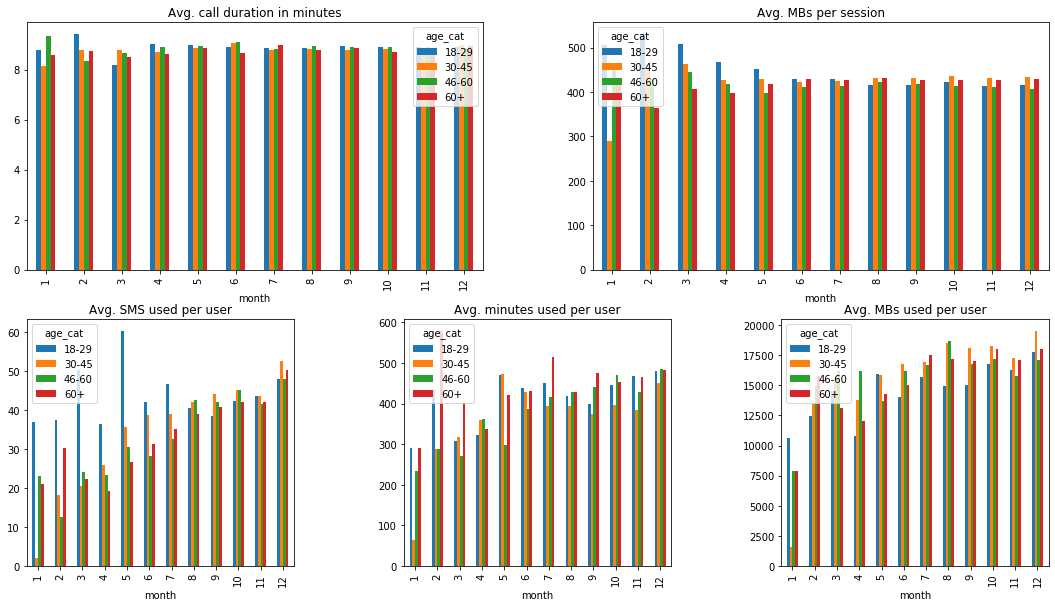

In [82]:
# Let's plot diagrams for age groups and look at their preferences

fig = plt.figure(figsize=(20, 10))

ax1 = plt.subplot2grid((2, 12), (0, 0), colspan=5)
ax1.set_title('Avg. call duration in minutes', fontsize=12)
ax2 = plt.subplot2grid((2, 12), (0, 6), colspan=5)
ax2.set_title('Avg. MBs per session', fontsize=12)
ax3 = plt.subplot2grid((2, 12), (1, 0), colspan=3)
ax3.set_title('Avg. SMS used per user', fontsize=12)
ax4 = plt.subplot2grid((2, 12), (1, 4), colspan=3)
ax4.set_title('Avg. minutes used per user', fontsize=12)
ax5 = plt.subplot2grid((2, 12), (1, 8), colspan=3)
ax5.set_title('Avg. MBs used per user', fontsize=12)

calls_age = calls.merge(users[['user_id', 'age_cat']])
data_age = data.merge(users[['user_id', 'age_cat']])
sms_age = sms.merge(users[['user_id', 'age_cat']])

calls_age.query('duration > 0').groupby(['age_cat', 'month'])['duration'].mean().unstack(level=0).plot(kind='bar', ax=ax1)
data_age.query('mb_used > 0').groupby(['age_cat', 'month'])['mb_used'].mean().unstack(level=0).plot(kind='bar', ax=ax2)
sms_age.groupby(['age_cat', 'month', 'user_id'])['id'].count().mean(level=['age_cat','month']).unstack(level=0).plot(kind='bar', ax=ax3)
calls_age.query('duration > 0').groupby(['age_cat', 'month', 'user_id'])['duration'].sum().mean(level=['age_cat','month']).unstack(level=0).plot(kind='bar', ax=ax4)
data_age.query('mb_used > 0').groupby(['age_cat', 'month', 'user_id'])['mb_used'].sum().mean(level=['age_cat','month']).unstack(level=0).plot(kind='bar', ax=ax5)

plt.show()

- Mainly the same **average call duration and data volumes per session** for all age groups *from June to the end* of the year but *till June* **young people** used **more MBs per session** compared to other age groups. 
- **Younger** people also used significantly **more SMS per month** *till July* compared to other age categories.
- As for calls: **young and old** people were leaders in minutes useage in the begining of the year.
- There was a race between age groups for monthly MBs usage during the year: the young we leaders in January, the next month the old were the leaders etc. the first prize transfered from group to group. There's no sugnificant leaders in this race so in average all people used MBs equally.

### Step 4. Test the hypotheses

1. The average profit from users of Ultimate and Surf calling plans differs.
2. The average profit from users in NY-NJ area is different from that of the users from other regions.

Let's take alpha 0.05 and use t-test to test the hypotheses.


For the **first** test the null hypothesis is:


$H_0$: The **average** profit (among monthly profit for each user) from users of Ultimate and Surf calling plans is equal

The alternative hypothesis is:

$H_1$: The **average** profit (among monthly profit for each user) from users of Ultimate and Surf calling plans differs.

In [54]:
profit_tariff.head()

profit      plan
user_id month                  
1000    12      70.00  ultimate
1001    8       20.00      surf
        9       20.00      surf
        10      90.09      surf
        11      60.00      surf

In [56]:
alpha = 0.05

surf_profit = profit_tariff.query('plan =="surf"')
ultimate_profit =  profit_tariff.query('plan =="ultimate"')

if surf_profit['plan'].count() != ultimate_profit['plan'].count():
    print("Two samples have different sizes!")

# As the sample variances are different we assume equal_var = False
result = st.ttest_ind(surf_profit['profit'].array, ultimate_profit['profit'].array,equal_var=False)
print('p-value: ', result.pvalue)
if result.pvalue < alpha:
    print('p-value is below significance level, so we have to reject the null hypothesis!')
else:
    print('p-value is above significance level, so we do not reject the null hypothesis!')

Two samples have different sizes!
p-value:  5.132491378110111e-97
p-value is below significance level, so we have to reject the null hypothesis!


## Results:

So we have to reject the null  hypothesis in favour of alternative:

$H_1$: The average profit from users of Ultimate and Surf calling plans differs.


For the **second** test we have the following:

$H_0$: The average profit from users in NY-NJ area equals that of the users from other regions.

and the alternative:

$H_1$: The average profit from users in NY-NJ area is different from that of the users from other regions.

In [57]:
users['is_NY_NJ'] = users['city'].str.contains('NY-NJ')
profit_city = pd.merge(profit_grouped.reset_index(),
      users[['user_id', 'is_NY_NJ']],
      on=['user_id'],
      how='inner'
     ).set_index(['user_id','month']).rename(columns={0:'profit'})
profit_city.head()


profit  is_NY_NJ
user_id month                  
1000    12      70.00     False
1001    8       20.00     False
        9       20.00     False
        10      90.09     False
        11      60.00     False

In [90]:
NY_NJ_profit = profit_city.query("is_NY_NJ == True")
Other_profit = profit_city.query("is_NY_NJ == False")

# Assume here equal variances
result = st.ttest_ind(NY_NJ_profit['profit'].array, Other_profit['profit'].array)
print('p-value: ', result.pvalue)
if result.pvalue < alpha:
    print('p-value is below significance level, so we have to reject the null hypothesis!')
else:
    print('p-value is above significance level, so we do not reject the null hypothesis!')

p-value:  0.03295416913977652
p-value is below significance level, so we have to reject the null hypothesis!


## Results:

Based in t-test we had to reject the null hypothesis. So we accept the alternative:<br>
    
    The average profit from users in NY-NJ area differs from that of the users from other regions.


In [91]:
profit_city.groupby('is_NY_NJ').agg({'profit':['mean', 'median', 'std', 'var'] })

profit                               
               mean median        std          var
is_NY_NJ                                          
False     56.180961  62.73  43.191081  1865.469460
True      51.918132  40.00  39.898806  1591.914726

NY-NJ seems to be a less profitable region.


### Conclusions

We have studied Megaline data on services usage and observed the following:
- The data has almost no missing values (except churn_date) which means the user is still active
- There's no duplicates in the data
- There're zero valued duration and mb_used columns which we assumed to be unsuccessful calls/sessions so we excluded them when calculated mean values.
- There were inconsistensies in the transactions: though the user was not active he had transactions at that time so we got rid of them.
- We made a number of calculations: 
    - built pivot tables to see monthly service usage for each user.
    - built profit table based on usage pivot tables to see monthly profit for each user
- We explored several parameters:
    - total minutes/MBs/messages usage for 2 plans/ 4 age groups
    - average call duration / session volume for 2 plans / 4 age groups
    - average monthly usage for each service for 2 plans / 4 age groups
- Surf users totally consume more because there're more Surf users than Ultimate users. At the same time average surf user uses less services as average ultimate user
- Plan limits for ultimate plan have overhead compared to average services usage by ultimate users, while surf average user exceeds plan limits for data services (MBs usage).
- Call duration and session volume have distributions skewed to the right .
- SMS count has a distribution far from normal shape, many values have almost equal frequency
- **Profit distribution for Surf is heavily skewed to the right with big deviation and a lot of outliers while Ultimate profit is concentrated arounf package price.**
- We've tested some hypotheses using t-test to compare 2 independent samples: surf and ultimate monthly profits (average among users), average profit from users in NY-NJ and for other cities.
- The test results are:
    - $H_1$: The **average**  profit from users of Ultimate and Surf calling plans differs.    
    - $H_1$: The **average** profit from users in NY-NJ area differs from that of the users from other regions.

**Recommendation**: Currently the most _profitable_ plan is the **Ultimate** plan but we observe the trend that some Surf users tend to pay significantly more than plan monthly price (during the last months of the year). We could promote data services for Surf users to make them use 5GB over the plan limits. 

At the same time Ultimate users do not tend to pay more than the package price and there's a lot of "unused" package resources so it might be difficult to make them use all the package and above.  
